In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
from skimage.filters.rank import median
from skimage.measure import regionprops
from skimage.morphology import disk
from skimage.segmentation import felzenszwalb
from skimage.transform import rescale
from skimage.util import img_as_ubyte
from scipy.ndimage import binary_fill_holes
from cv2 import resize
#from scipy.misc import imresize
from PIL import Image

In [2]:
im_files = []
for folder in os.listdir('.\images'):
    for file in os.listdir(f'.\images\\{folder}'):
        im_files.append(f'.\images\\{folder}\\{file}')
print(im_files)

['.\\images\\10006\\1459541791.dcm', '.\\images\\10006\\1864590858.dcm', '.\\images\\10006\\1874946579.dcm', '.\\images\\10006\\462822612.dcm', '.\\images\\10011\\1031443799.dcm', '.\\images\\10011\\220375232.dcm', '.\\images\\10011\\270344397.dcm', '.\\images\\10011\\541722628.dcm', '.\\images\\10025\\1365269360.dcm', '.\\images\\10025\\288394860.dcm', '.\\images\\10025\\562340703.dcm', '.\\images\\10025\\893612858.dcm', '.\\images\\10038\\1350492010.dcm', '.\\images\\10038\\1967300488.dcm', '.\\images\\10038\\2142944869.dcm', '.\\images\\10038\\850559196.dcm', '.\\images\\10042\\102733848.dcm', '.\\images\\10042\\1648588715.dcm', '.\\images\\10042\\202939811.dcm', '.\\images\\10042\\294481519.dcm', '.\\images\\10042\\495770405.dcm', '.\\images\\10130\\1013166704.dcm', '.\\images\\10130\\1165309236.dcm', '.\\images\\10130\\1360338805.dcm', '.\\images\\10130\\1672636630.dcm', '.\\images\\10130\\2110820077.dcm', '.\\images\\10130\\388811999.dcm', '.\\images\\10130\\613462606.dcm']


In [3]:
imgs = []
for file in im_files:
    ds = pydicom.dcmread(file) #Read .dcm file
    if ds.PhotometricInterpretation == 'MONOCHROME1':
        img = ds.pixel_array.max() - ds.pixel_array
    if ds.PhotometricInterpretation == 'MONOCHROME2':
        img = ds.pixel_array - ds.pixel_array.min()
    imgs.append(img)

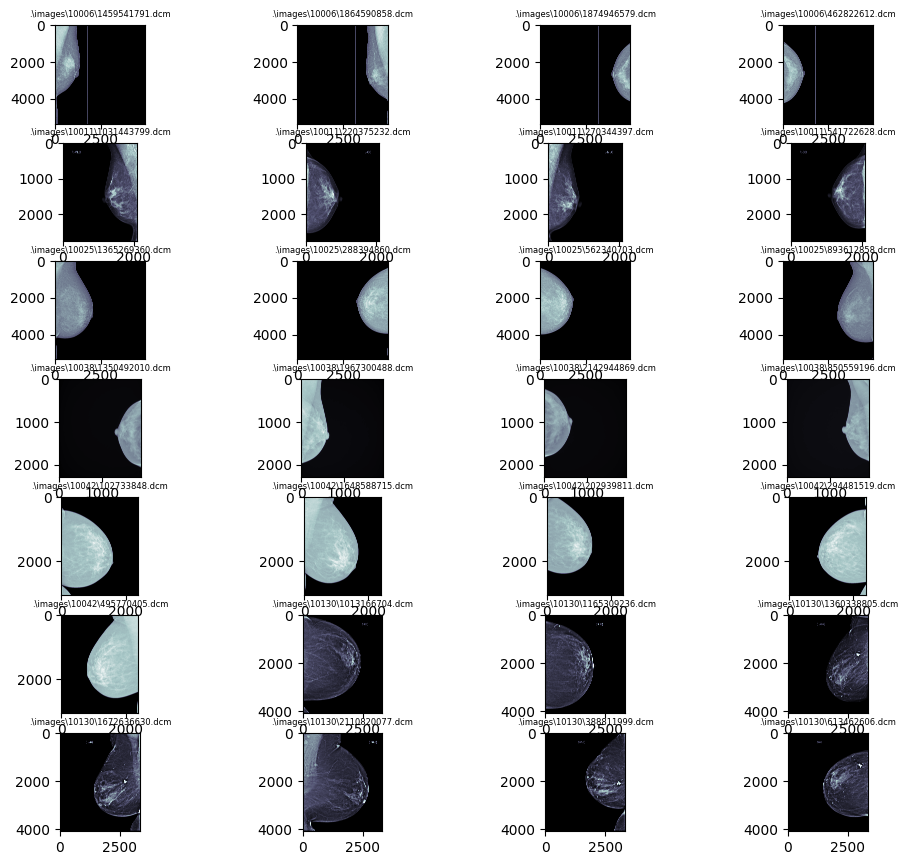

In [4]:
%matplotlib inline
plt.figure(figsize=(12,12))
for i, img in enumerate(imgs):
    plt.subplot(len(imgs)//4 + 1, 4, i+1)
    plt.title(im_files[i], fontsize=6)
    plt.imshow(img, cmap='bone')

In [50]:
def get_segment_crop(image, max_x, max_y, tol=100, mask=None):
    if mask is None:
        mask = image > tol
    farthest_pixel = np.max(list(zip(*np.where(mask == 1))), axis=0)
    nearest_pixel = np.min(list(zip(*np.where(mask == 1))), axis=0)
    if farthest_pixel[0] > max_x | nearest_pixel[1] > max_y:
        cropped = img[nearest_pixel[0]:farthest_pixel[0], nearest_pixel[1]:farthest_pixel[1]]
    else:
        cropped = img[0:max_x, 0:max_y]
    #cropped = resize(cropped, (min_x, min_y))
    return cropped

In [51]:
im_shapes = {'H':[],'W':[]}
for im in imgs:
    im_shapes['H'].append( im.shape[0] )
    im_shapes['W'].append( im.shape[1] )
im_shapes_df = pd.DataFrame(im_shapes)
im_shapes_df['A'] = im_shapes_df['H'] * im_shapes_df['W']
idx = im_shapes_df[im_shapes_df['A'] == im_shapes_df['A'].max()].idxmin()

max_x = im_shapes_df['W'][idx].values[0]
max_y = im_shapes_df['H'][idx].values[0]
print(max_x, max_y)

4915 5355


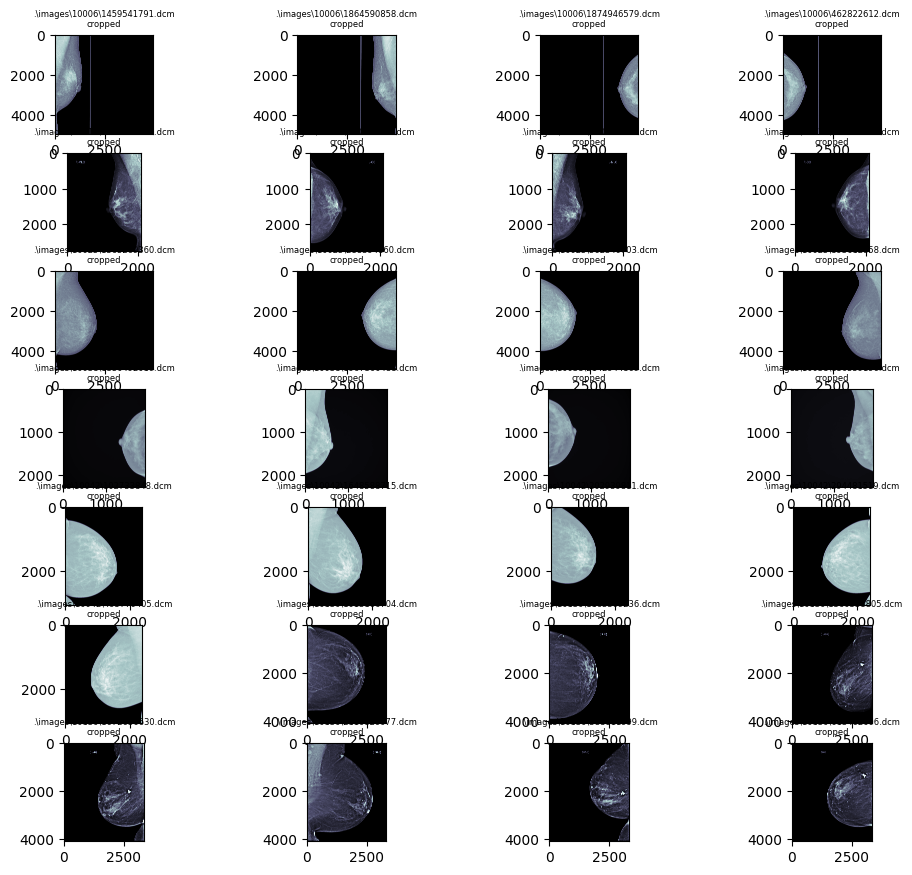

In [52]:
%matplotlib inline
tts = []
plt.figure(figsize=(12,12))
for i, img in enumerate(imgs):
    tt = get_segment_crop(img, max_y=max_y, max_x=max_x)
    tts.append(tt)
    plt.subplot(len(imgs)//4 + 1, 4, i+1)
    plt.title(im_files[i] + '\ncropped', fontsize=6)
    plt.imshow(tt, cmap='bone')

In [53]:
def histogram_equalization(img):
    m = int(np.max(img))
    hist = np.histogram(img, bins=m+1, range=(0, m+1))[0]
    hist = hist/img.size
    cdf = np.cumsum(hist)
    s_k = (255 * cdf)
    img_new = np.array([s_k[i] for i in img.ravel()],dtype=np.uint8).reshape(img.shape)
    return img_new

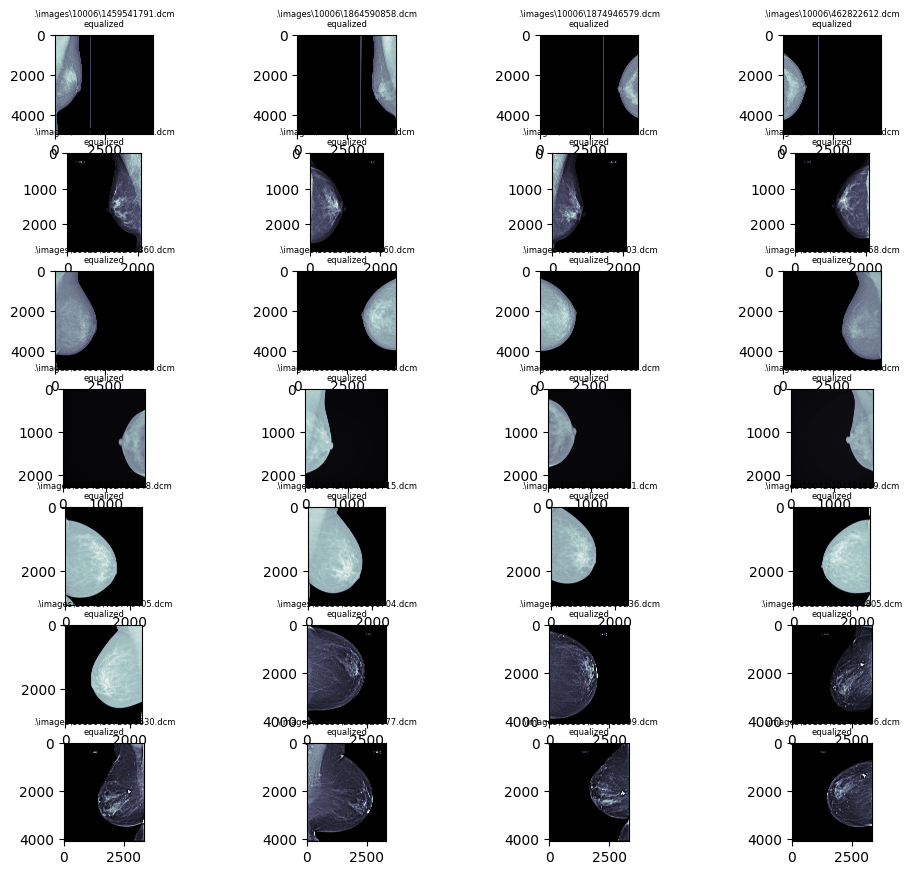

In [54]:
%matplotlib inline
plt.figure(figsize=(12,12))
for i, tt in enumerate(tts):
    img_eq = histogram_equalization(tt)
    plt.subplot(len(tts)//4 + 1, 4, i+1)
    plt.title(im_files[i] + '\nequalized', fontsize=6)
    plt.imshow(tt, cmap='bone')

In [56]:
for i, im in enumerate(tts):
    print(im.shape, imgs[i].shape)

(4915, 4915) (5355, 4915)
(4915, 4915) (5355, 4915)
(4915, 4915) (5355, 4915)
(4915, 4915) (5355, 4915)
(2776, 2082) (2776, 2082)
(2776, 2082) (2776, 2082)
(2776, 2082) (2776, 2082)
(2776, 2082) (2776, 2082)
(4915, 4915) (5355, 4915)
(4915, 4915) (5355, 4915)
(4915, 4915) (5355, 4915)
(4915, 4915) (5355, 4915)
(2294, 1914) (2294, 1914)
(2294, 1914) (2294, 1914)
(2294, 1914) (2294, 1914)
(2294, 1914) (2294, 1914)
(3062, 2394) (3062, 2394)
(3062, 2394) (3062, 2394)
(3062, 2394) (3062, 2394)
(3062, 2394) (3062, 2394)
(3062, 2394) (3062, 2394)
(4096, 3328) (4096, 3328)
(4096, 3328) (4096, 3328)
(4096, 3328) (4096, 3328)
(4096, 3328) (4096, 3328)
(4096, 3328) (4096, 3328)
(4096, 3328) (4096, 3328)
(4096, 3328) (4096, 3328)
